In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Inputs

In [2]:
# data
n = 1000
noise = .2
test_size = .2
val_size = .3

# model
# modelName, model_nbFeat, model_h = 'LinearNet', None, None
# modelName, model_nbFeat, model_h = 'FCNet', 10, None
modelName, model_nbFeat, model_h = 'DeepNet', 10, 20

# seed
seed = 11 # 10 does not work for DeepNet_degenerateLast
def set_seed(seed = 8):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(seed)

## Data

In [3]:
# synthetic data
X, y = make_moons(n_samples=n, shuffle=True, noise=noise, random_state=seed)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=test_size,
                                                          random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=val_size,
                                                  random_state=seed)

# grid (for plots)
_x, _y = np.linspace(-3, 3, 50), np.linspace(-2, 2, 50)
_xx, _yy = np.meshgrid(_x, _y)
_xx, _yy = _xx.flatten(), _yy.flatten()
grid = torch.tensor(np.vstack((_xx, _yy)).transpose(), dtype=torch.float).view(-1, 2)

Text(0.5, 1.0, 'toy data')

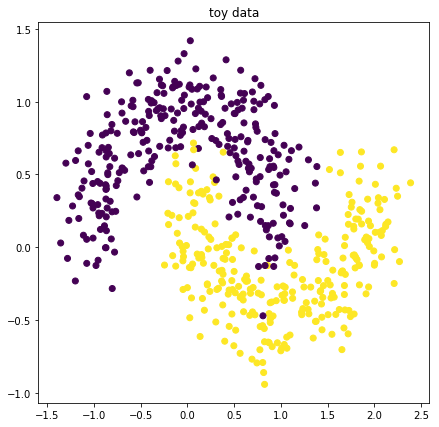

In [4]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, marker = 'o')
ax.set_title('toy data')

## Experiments

In [5]:
# define model
class Net(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self, name, nbFeat=None, h=None):
        super().__init__()
        
        self.name = name
        self.nbFeat = nbFeat
        
        if self.name == 'LinearNet':
            self.nbFeat = Net.inputDim
            self.nbEpochs = 100
            self.lr = 0.001 # use RMSProp
            
        elif self.name == 'FCNet':
            if nbFeat is None:
                raise ValueError('nbFeat cannot be None for this net')
            self.fc1 = nn.Linear(Net.inputDim, self.nbFeat)
            self.nbEpochs = 1000
            self.lr = 0.001 # use RMSProp
            
        elif self.name == 'DeepNet':
            if nbFeat is None or h is None:
                raise ValueError('nbFeat and h cannot be None for this net')
            self.fc1 = nn.Linear(Net.inputDim, h)
            self.fc2 = nn.Linear(h, h)
            self.fc3 = nn.Linear(h, h)
            self.fc4 = nn.Linear(h, self.nbFeat)
            self.nbEpochs = 1000
            self.lr = 0.001 # use RMSProp
        else:
            raise ValueError('unkown model name: {}'.format(self.name))

        self.w = nn.Linear(self.nbFeat, Net.outputDim) # initializes at random
        
    def featurize(self, x):
        for name,layer in self.named_children():
            if 'fc' in name:
                x = torch.relu(layer(x))
        return x
    
    def score(self, x):
        x = self.featurize(x)
        x = self.w(x)
        return x
    
    def forward(self, x):
        x = torch.sigmoid(self.score(x))
        return x

In [6]:
# # define model
# class BasicNet(nn.Module):
    
#     inputDim = 2
#     outputDim = 1
    
#     def __init__(self):
#         super().__init__()
        
#         self.fc1 = nn.Linear(BasicNet.inputDim, BasicNet.outputDim) # initializes at random
        
#     def featurize(self, x):
#         return x
    
#     def forward(self, x):
#         x = self.featurize(x)
#         x = torch.sigmoid(self.fc1(x))
#         return x
    
#     def predict(self, x):
#         x = self.forward(x)
#         x[x < 1/2] = 0
#         x[x>= 1/2] = 1
#         return x

In [7]:
# # define model
# class FCNet(nn.Module):
    
#     inputDim = 2
#     outputDim = 1
    
#     def __init__(self, h):
#         """ h: number of units in hidden layer """
#         super().__init__()
        
#         self.fc1 = nn.Linear(FCNet.inputDim, h) # initializes at random
#         self.fc2 = nn.Linear(h, FCNet.outputDim) # initializes at random

#     def featurize(self, x):
#         x = torch.relu(self.fc1(x))        
#         return x
    
#     def forward(self, x):
#         x = self.featurize(x)
#         x = torch.sigmoid(self.fc2(x))
#         return x
    
#     def predict(self, x):
#         x = self.forward(x)
#         x[x < 1/2] = 0
#         x[x>= 1/2] = 1
#         return x

In [8]:
# # define model
# class DeepNet(nn.Module):
    
#     inputDim = 2
#     outputDim = 1
    
#     def __init__(self, h, degenerateLast=False):
#         """
#         h: number of units per hidden layer
#         """
#         super().__init__()
        
#         self.fc1 = nn.Linear(DeepNet.inputDim, h) # initializes at random
#         self.fc2 = nn.Linear(h, h) # initializes at random
#         self.fc3 = nn.Linear(h, h) # initializes at random
#         if not degenerateLast:
#             self.fc4 = nn.Linear(h, h) # initializes at random
#             self.fc5 = nn.Linear(h, DeepNet.outputDim) # initializes at random
#         else:
#             self.fc4 = nn.Linear(h, 1) # initializes at random
#             self.fc5 = nn.Linear(1, DeepNet.outputDim) # initializes at random
            
#     def featurize(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         return x
        
#     def forward(self, x):
#         x = self.featurize(x)
#         x = torch.sigmoid(self.fc5(x))
#         return x
    
#     def predict(self, x):
#         x = self.forward(x)
#         x[x < 1/2] = 0
#         x[x>= 1/2] = 1
#         return x

In [9]:
# instanciate model and setup
# if modelName == 'BasicNet':
#     model = BasicNet(); nbEpochs = 100; lr=0.01 # use RMSProp
# elif modelName == 'FCNet':
#     model = FCNet(20); nbEpochs = 100; lr=0.01 # use RMSProp
# elif modelName == 'DeepNet':
#     model = DeepNet(100); nbEpochs = 500; lr=0.001 # use RMSProp
# elif modelName == 'DeepNet_degenerateLast':
#     model = DeepNet(100, degenerateLast=True); nbEpochs = 500; lr=0.001 # use RMSProp
# else:
#     raise ValueError('unkown modelName: {}'.format(modelName))
model = Net(modelName, model_nbFeat, model_h)

lossfn = nn.BCELoss() # BinaryCrossEntropy
# optimizer = optim.SGD(model.parameters(), lr=0.1) # using a better optimizer DOES make a difference
optimizer = optim.RMSprop(model.parameters(),
                          lr=model.lr,
                          alpha=0.99,
                          eps=1e-08,
                          weight_decay=0,
                          momentum=0.9,
                          centered=False)
# optimizer = optim.Adam(model.parameters(),
#                        lr=0.01,
#                        betas=(0.9, 0.999),
#                        eps=1e-08,
#                        weight_decay=0,
#                        amsgrad=False)
for p in model.named_children():
    print(p)

('fc1', Linear(in_features=2, out_features=20, bias=True))
('fc2', Linear(in_features=20, out_features=20, bias=True))
('fc3', Linear(in_features=20, out_features=20, bias=True))
('fc4', Linear(in_features=20, out_features=10, bias=True))
('w', Linear(in_features=10, out_features=1, bias=True))


[1] error: 0.6966031193733215
[11] error: 0.4133093059062958
[21] error: 0.23495440185070038
[31] error: 0.16019217669963837
[41] error: 0.10532510280609131
[51] error: 0.07209457457065582
[61] error: 0.06274934858083725
[71] error: 0.05689619109034538
[81] error: 0.05505731329321861
[91] error: 0.054332245141267776
[101] error: 0.053592078387737274
[111] error: 0.05298689007759094
[121] error: 0.05251465365290642
[131] error: 0.052017271518707275
[141] error: 0.05159986391663551
[151] error: 0.05112705007195473
[161] error: 0.050688087940216064
[171] error: 0.05034363642334938
[181] error: 0.05010597035288811
[191] error: 0.05003979429602623
[201] error: 0.049893949180841446
[211] error: 0.049273330718278885
[221] error: 0.04904188588261604
[231] error: 0.049009427428245544
[241] error: 0.0488462820649147
[251] error: 0.04869154840707779
[261] error: 0.04851263761520386
[271] error: 0.04859759658575058
[281] error: 0.048699524253606796
[291] error: 0.04877394437789917
[301] error: 0.0

Text(0.5, 1.0, 'train loss')

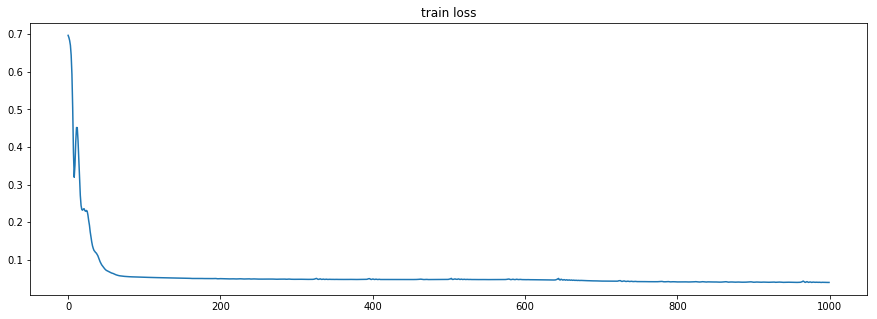

In [10]:
# train model
_X = torch.tensor(X_train, dtype=torch.float)
_y = torch.tensor(y_train, dtype=torch.float).view(-1, 1) # reshape with one column
_aloss = []

for epoch in range(model.nbEpochs):  # loop over the dataset multiple times
  
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # no minibatch here: take whole dataset
    fX = model(_X)
    loss = lossfn(fX, _y); _aloss.append(loss)
    loss.backward()
    optimizer.step()
        
    # print statistics
    if epoch % 10 == 0:
        print('[{}] error: {}'.format(epoch + 1, loss))

fX = model(_X)
loss = lossfn(fX, _y)
print('[last] error: {}'.format(loss))

print('Finished Training')

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(_aloss)
ax.set_title('train loss')

Text(0.5, 1.0, 'prediction')

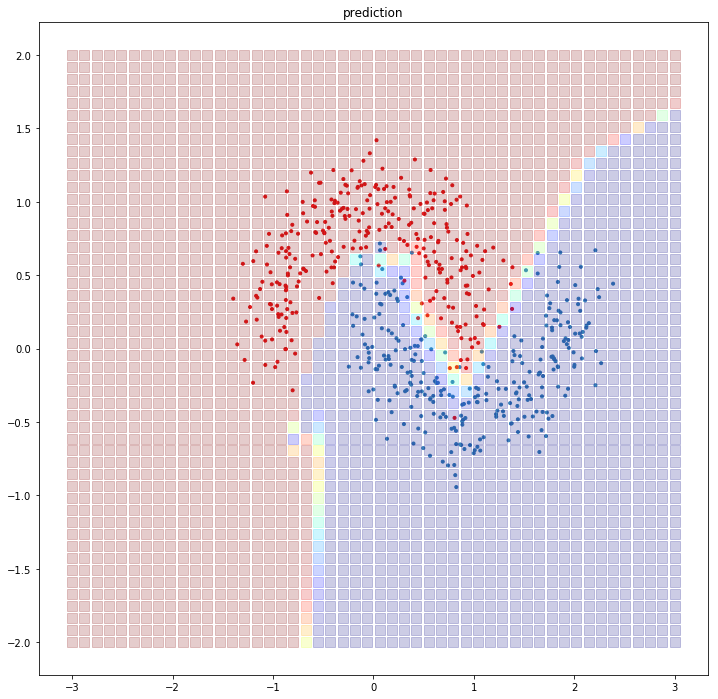

In [11]:
_gridHat = model(grid).detach().numpy().flatten()

f = plt.figure(figsize=(12,12))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=cm.Set1(y_train), marker = '.')
ax.scatter(grid[:,0], grid[:,1], c=cm.jet(1-_gridHat), s=100, marker = 's', alpha=.2)
ax.set_title('prediction')

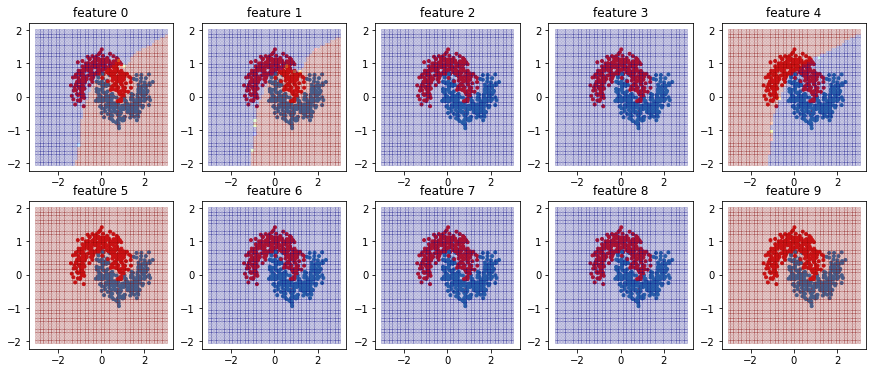

In [12]:
_gridHatFeat = model.featurize(grid).detach().numpy()

K = _gridHatFeat.shape[1]
nc = 5
nr = int(np.ceil(K/nc))

f = plt.figure(figsize=(3*nc,3*nr))
for k in range(K):
    tmp = _gridHatFeat[:,k]
    
    ax = f.add_subplot(nr,nc,1+k)
    ax.scatter(X_train[:,0], X_train[:,1], c=cm.Set1(y_train), marker = '.')
    ax.scatter(grid[:,0], grid[:,1], c=cm.jet(tmp), s=5, marker = 's', alpha=.2)
    ax.set_title('feature {}'.format(k))